# XGBoost-CSMA Example Notebook

This notebook demonstrates the XGBoost-CSMA model training, evaluation, validation, and SHAP interpretation.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
import pickle
import warnings

from model import XGBoostCSMA
import utils

warnings.filterwarnings("ignore", message=".*Parameters.*might not be used.*")
%matplotlib inline

In [28]:
# --- Configuration ---
# Assuming notebook is in src/, and dataset is in ../dataset/
root_path = '../' 
dataset_path = os.path.join(root_path, 'dataset/')
save_path = os.path.join(root_path, 'performance/')
results_save_path = os.path.join(root_path, 'results/')
shap_save_path = os.path.join(results_save_path, 'SHAP/')

for p in [save_path, results_save_path, shap_save_path]:
    if not os.path.exists(p):
        os.makedirs(p)

In [29]:
# --- Load Data ---
dataset_name = 'T1'
csv_path = os.path.join(dataset_path, f"{dataset_name}.csv")

print(f"Loading dataset: {dataset_name}...")
if not os.path.exists(csv_path):
    print(f"Error: Dataset not found at {csv_path}")
    print("Please ensure you are running this notebook from the 'src' directory and the dataset exists in '../dataset/'.")
else:
    features, labels = utils.load_and_preprocess_data(csv_path)
    print("Data loaded.")

Loading dataset: T1...
Data loaded.


In [30]:
# --- Data Split ---
try:
    with open(dataset_path + '{}.pickle'.format(dataset_name),'rb') as f:
        shuffle_index = pickle.load(f)
    
    train_ratio = 0.7
    valid_ratio = 0.15
    
    train_index = shuffle_index[:int(features.shape[0] * train_ratio)]
    valid_index = shuffle_index[int(features.shape[0] * train_ratio):int(features.shape[0] * (train_ratio + valid_ratio))]
    test_index = shuffle_index[int(features.shape[0] * (train_ratio + valid_ratio)):]
    
    # Using .iloc to access rows by integer position from the shuffled indices
    # features is a dataframe, labels is a series
    X_train, y_train = features.iloc[train_index], labels.iloc[train_index]
    X_valid, y_valid = features.iloc[valid_index], labels.iloc[valid_index]
    X_test, y_test = features.iloc[test_index], labels.iloc[test_index]

    # --- Optimization: Reset Index and Rename Columns for SHAP ---
    # Reset index to avoid IndexError in SHAP plots
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Rename columns to avoid Glyph missing errors (Chinese fonts)
    # Assuming 54 features as per output. We generate generic LaTeX names.
    # Note: If features has different number of columns, this adapts.
    new_columns = [f'$X_{{{i+1}}}$' for i in range(X_test.shape[1])]
    X_train.columns = new_columns
    X_valid.columns = new_columns
    X_test.columns = new_columns
    
    print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}, Test shape: {X_test.shape}")
except Exception as e:
    print(f"Error loading split or processing data: {e}")
    # Simple fallback split if pickle missing
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Apply same fixes to fallback
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    new_columns = [f'$X_{{{i+1}}}$' for i in range(X_test.shape[1])]
    X_train.columns = new_columns
    X_valid.columns = new_columns
    X_test.columns = new_columns

    print("Used random split fallback.")
    print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}, Test shape: {X_test.shape}")


Train shape: (38639, 54), Valid shape: (8280, 54), Test shape: (7964, 54)


In [31]:
# --- Hyperparameter Search (Simplified for Example) ---
# To save time, we use a smaller search space or just the best params if known.
# Here is a small search example.
a_values = [13]  # Example value
c_values = [0.5] # Example value
# Uncomment below for wider search
# a_values = np.arange(5, 16, 5)
# c_values = np.arange(0.1, 1.1, 0.5)

best_score = 0
best_params = {'a': 13, 'c': 0.5}

print("Starting simplified search...")
for a in a_values:
    for c in c_values:
        model = XGBoostCSMA(a=a, c=c, eval_metric=['auc'], early_stopping_rounds=10, loss_type='cross_entropy')
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        y_valid_pred = np.rint(model.predict_proba(X_valid)[:, 1])
        score = utils.g_mean_score(y_valid, y_valid_pred)
        
        if score > best_score:
            best_score = score
            best_params = {'a': a, 'c': c}
            print(f"New best G-mean: {best_score:.4f} (a={a}, c={c:.1f})")

print(f"Best Params: {best_params}")

Starting simplified search...
[10:42:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "a", "c", "loss_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


New best G-mean: 0.9144 (a=13, c=0.5)
Best Params: {'a': 13, 'c': 0.5}


In [32]:
# --- Train Final Model with Loss Tracking ---
print(f"Training Final Model...")

# Note: We add 'logloss' to eval_metric to track the loss curve specifically
# XGBoostCSMA passes kwargs to super().__init__, so we can add n_estimators etc if needed.
final_model = XGBoostCSMA(
    a=best_params['a'], 
    c=best_params['c'],
    eval_metric=['auc', 'logloss'], 
    early_stopping_rounds=20,
    n_estimators=300
)

# Fit allows tracking evals_result
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False
)

# Predict
y_test_proba = final_model.predict_proba(X_test)[:, 1]
metrics = utils.calc_metrics(y_test, y_test_proba)
print("\nTest Metrics:")
print(metrics)

Training Final Model...
[10:42:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "a", "c", "loss_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Test Metrics:
{'AUC': 0.9612653715332287, 'Gmean': 0.9082951062292475, 'TPR': 0.91875, 'KS': 0.8209674254317112, 'F1': 0.42180774748923955, 'LogLoss': 0.28833072500337065}


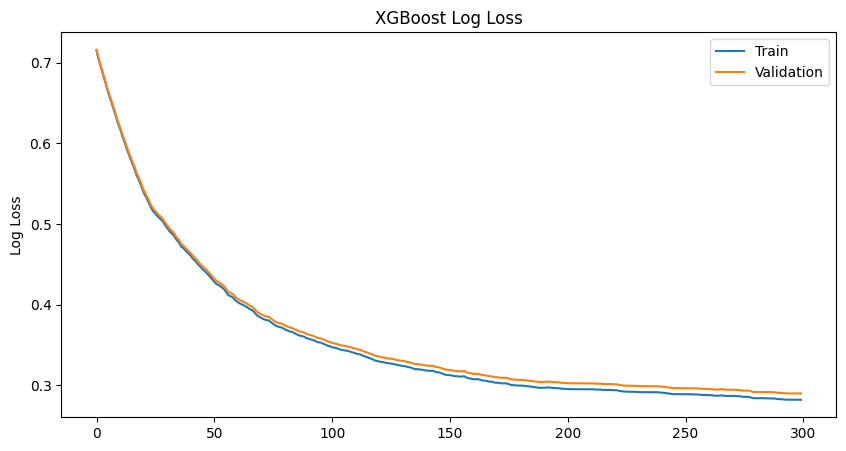

In [33]:
# --- Plot Loss Curve ---
results = final_model.evals_result()
# Check if logloss is in results (depends on XGBoost version and eval_metric)
if 'validation_0' in results and 'logloss' in results['validation_0']:
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
else:
    print("Log loss not found in evals_result. Available keys:", results.keys())

In [37]:
features.columns = [r'$X_1$',r'$X_2$',r'$X_3$',r'$X_4$',r'$X_5$',r'$X_6$',r'$X_7$',r'$X_8$',r'$X_9$',r'$X_{10}$',r'$X_{11}$',r'$X_{12}$',
         r'$X_{13}$',r'$X_{14}$',r'$X_{15}$',r'$X_{16}$',r'$X_{17}$',r'$X_{18}$',r'$X_{19}$',r'$X_{20}$',r'$X_{21}$',r'$X_{22}$',r'$X_{23}$',
         r'$X_{24}$',r'$X_{25}$',r'$X_{26}$',r'$X_{27}$',r'$X_{28}$',r'$X_{29}$',r'$X_{30}$',r'$X_{31}$',r'$X_{32}$',r'$X_{33}$',
         r'$X_{34}$',r'$X_{35}$',r'$X_{36}$',r'$X_{37}$',r'$X_{38}$',r'$X_{39}$',r'$X_{40}$',r'$X_{41}$',r'$X_{42}$',r'$X_{43}$',
         r'$X_{44}$',r'$X_{45}$',r'$X_{46}$',r'$X_{47}$',r'$X_{48}$',r'$X_{49}$',r'$X_{50}$',r'$X_{51}$',r'$X_{52}$',r'$X_{53}$',
         r'$X_{54}$']
labels0 = labels[labels == 0]
features0 = features.iloc[labels0.index,:]
labels1 = labels[labels == 1]
features1 = features.iloc[labels1.index,:]
print(features1.shape,labels1.shape,labels0.shape)

(2188, 54) (2188,) (53011,)


In [38]:
import shap 
shap.initjs()
booster = final_model.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(features)

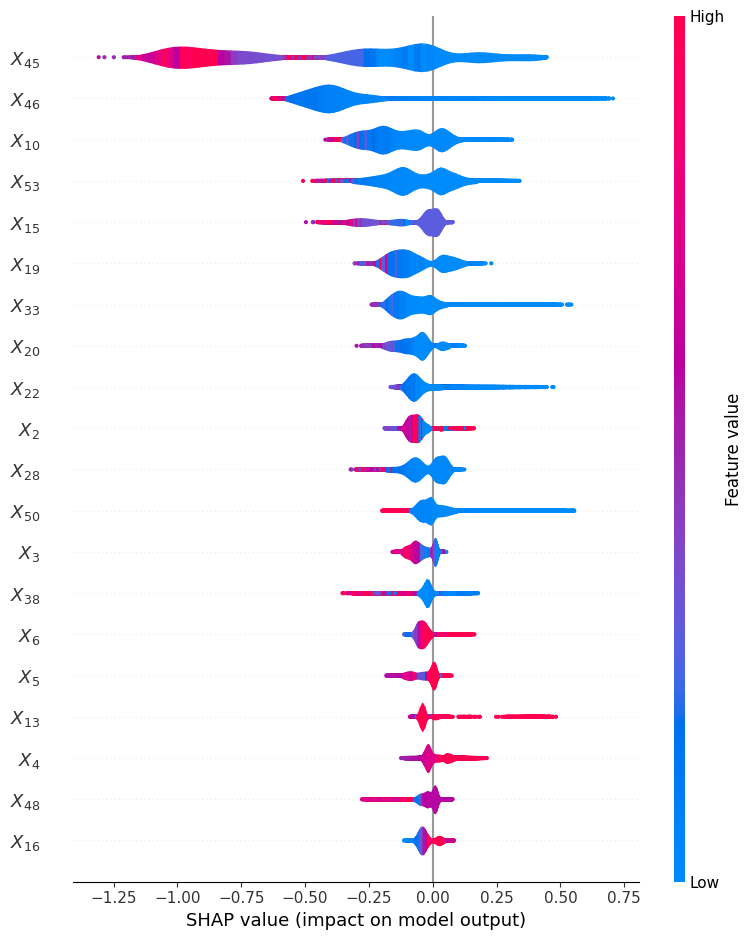

In [39]:
shap.summary_plot(shap_values,features,plot_type = 'violin',show = False)
plt.show()

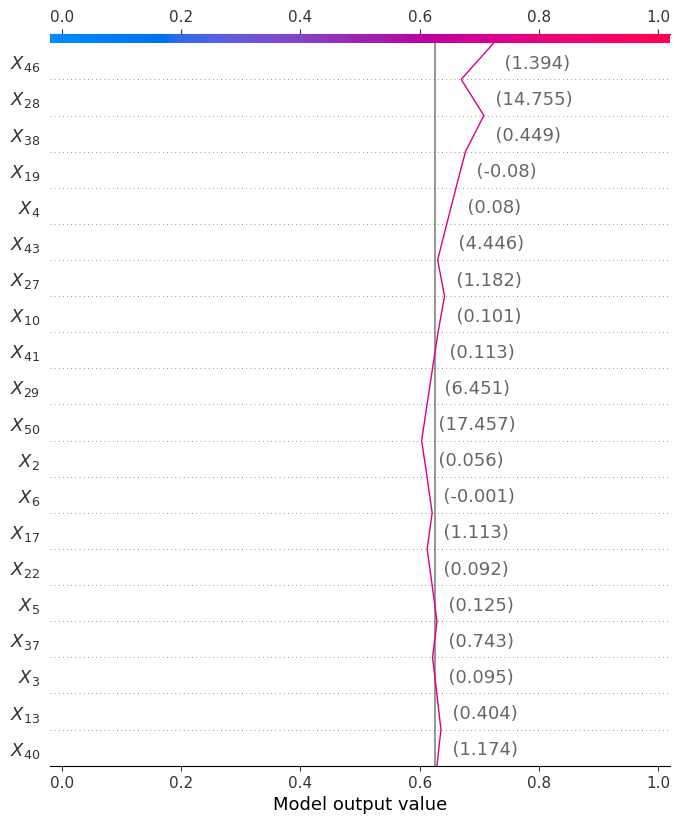

In [40]:
shap.decision_plot(explainer.expected_value,shap_values[list(labels1.index)[11],:],features1.iloc[11,:],link = 'logit',show = False)
plt.show()

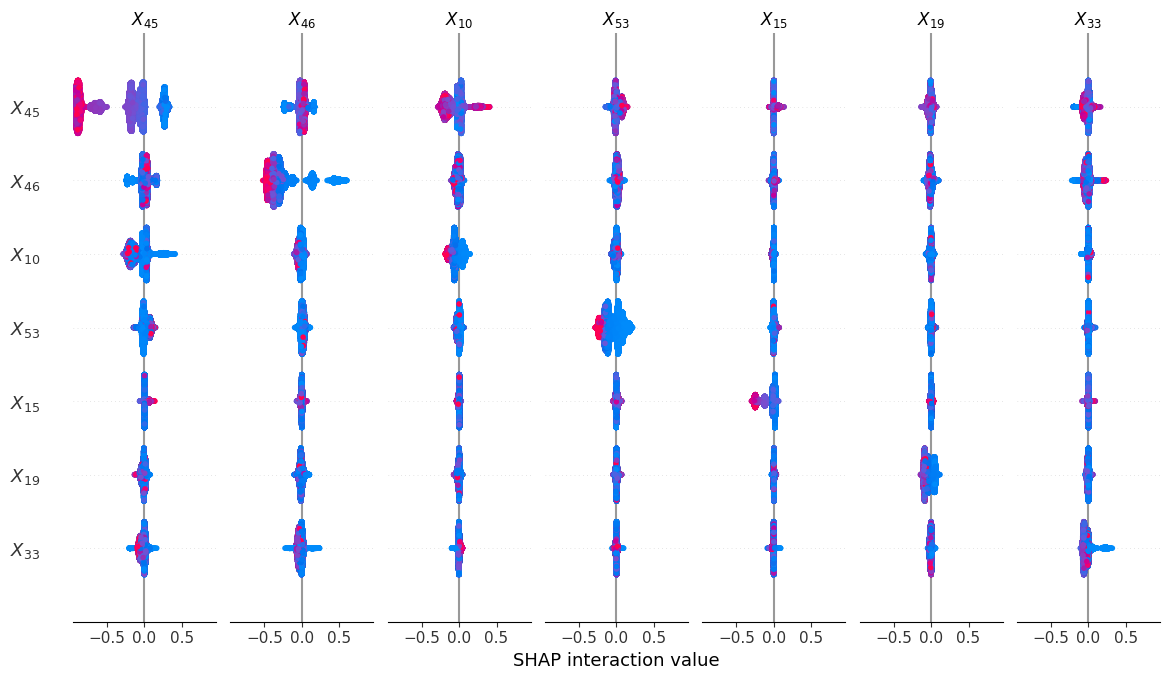

In [41]:
shap_interaction_values = explainer.shap_interaction_values(features)
shap.summary_plot(shap_interaction_values,features,show = False)
plt.show()

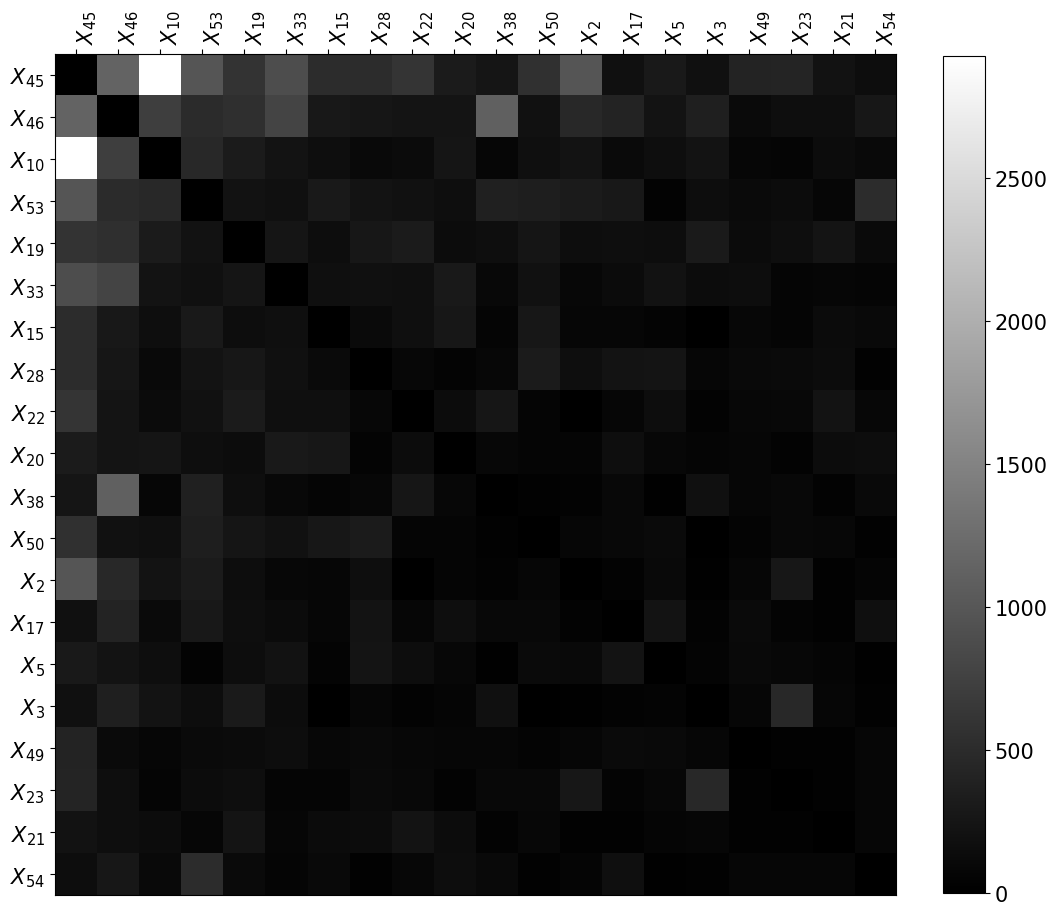

In [42]:
tmp = np.abs(shap_interaction_values).sum(0)

col_names = np.array(list(features.columns))
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:20]
tmp2 = tmp[inds,:][:,inds]
col_names = col_names[inds]
plt.figure(figsize = (12,12))
plt.imshow(tmp2,cmap = 'gray')
cb = plt.colorbar(fraction = 0.045)
cb.ax.tick_params(labelsize = 15)
plt.yticks(np.arange(tmp2.shape[0]),col_names,rotation = 0,horizontalalignment = 'right')
plt.xticks(np.arange(tmp2.shape[0]),col_names,rotation = 90,horizontalalignment = 'left')
plt.tick_params(labelsize = 15)
plt.gca().xaxis.tick_top()

plt.show()